In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def vvv_format(title='', ylabel='', autoscale=False, min=0, max=1, legend=True):

    plt.grid()
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    if legend:
        plt.legend()
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()

plt.rcParams['figure.figsize'] = 12, 8
    
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}

In [3]:
%%time 

# load the data

store = pd.HDFStore('ngram-data.h5')
grams = store['ngram_data']
grams = grams[~pd.isnull(grams.ngram)]

CPU times: user 4.58 s, sys: 522 ms, total: 5.1 s
Wall time: 5.1 s


In [4]:
def top_tokens(df):
    chi = top_ten_for_speaker(df, 'CHI')
    mot = top_ten_for_speaker(df, 'MOT')
    shared = len(np.intersect1d(chi.index, mot.index))
    if shared == 0:
        return pd.Series(
        {'chi_shares': 0,
         'mot_shares': 0}
    )
    return pd.Series(
        {'chi_shares': shared / len(chi),
         'mot_shares': shared / len(mot)}
    )

In [5]:
def get_top_types(df):
    counts = df.ngram.value_counts()
    if len(counts) == 0:
        return counts
    
    cutoff = counts[:10][-1]
    return counts[counts >= cutoff]

# observe that in this case we cut off after 10 tokens

test_data = grams[grams.speaker.eq('CHI')].head(100)
test_data.ngram.value_counts()[:10]

it       7
that     7
what     7
's       6
yeah     4
a        4
eat      3
I        3
teddy    3
big      3
Name: ngram, dtype: int64

In [6]:
# but here, since there are other tokens that tie with 3 examples, (in this case only 1, "big")
# we end up with 11 top tokens.

get_top_types(test_data)

it       7
that     7
what     7
's       6
yeah     4
a        4
eat      3
I        3
teddy    3
big      3
push     3
Name: ngram, dtype: int64

# Ratio of Top Tokens to Total Tokens

In [7]:
def top_token_total_token_ratio(df):
    """ df contains only data from a single speaker and session """
    top_types = get_top_types(df)
    return sum(top_types) / len(df)

In [8]:
get_top_types(grams.head(10))

baby    3
it      2
here    1
's      1
fit     1
will    1
n't     1
Name: ngram, dtype: int64

In [9]:
top_token_total_token_ratio(grams.head(10)), top_token_total_token_ratio(grams.head(40))

(1.0, 0.59999999999999998)

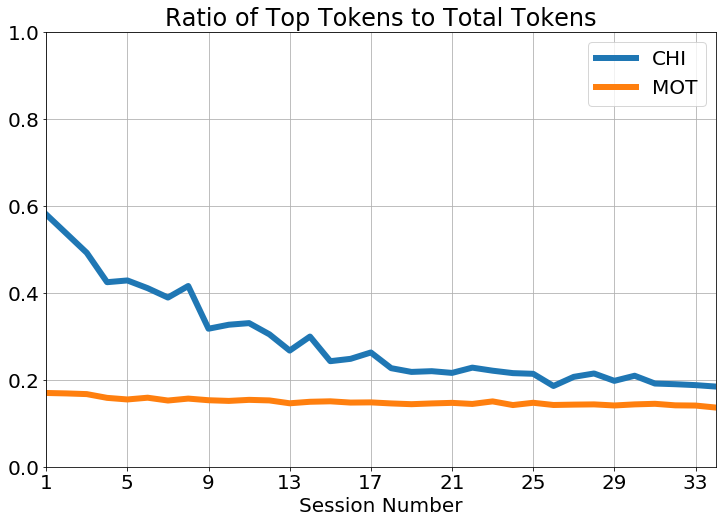

In [10]:
ttr = (
    grams.groupby(['gramsize', 'corpus', 'session', 'speaker'])
    .apply(top_token_total_token_ratio)
)
ttr.unstack('speaker').mean(level='session').plot()
vvv_format(title="Ratio of Top Tokens to Total Tokens")

# Shared Types 1

## How many of the parent's Top Types also exist in the child's Top Types

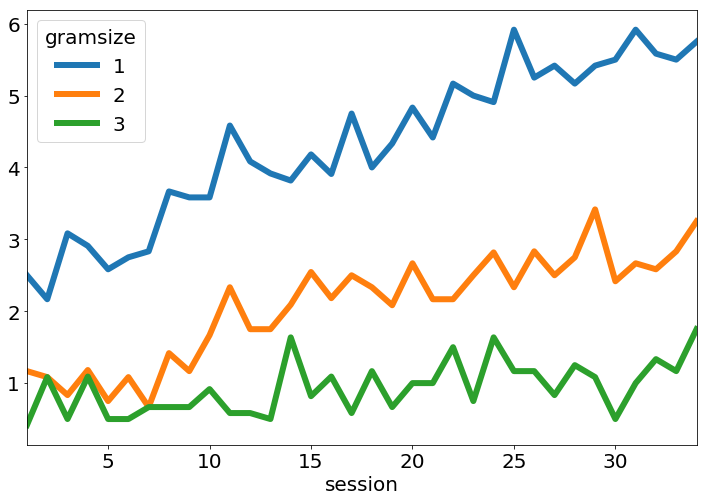

In [11]:
def num_shared_top_types(df):
    """ df contains data from both speakers """
    tops = df.groupby('speaker').apply(get_top_types)
    chi, mot = tops.CHI, tops.MOT
    shared = np.intersect1d(chi.index, mot.index)
    return len(shared)

stt = (
    grams.groupby(['gramsize', 'corpus', 'session'])
    .apply(num_shared_top_types)
)
stt.mean(level=['gramsize', 'session']).unstack('gramsize').plot()
#vvv_format(title="Number of Shared Top Types", legend=False, autoscale=False)

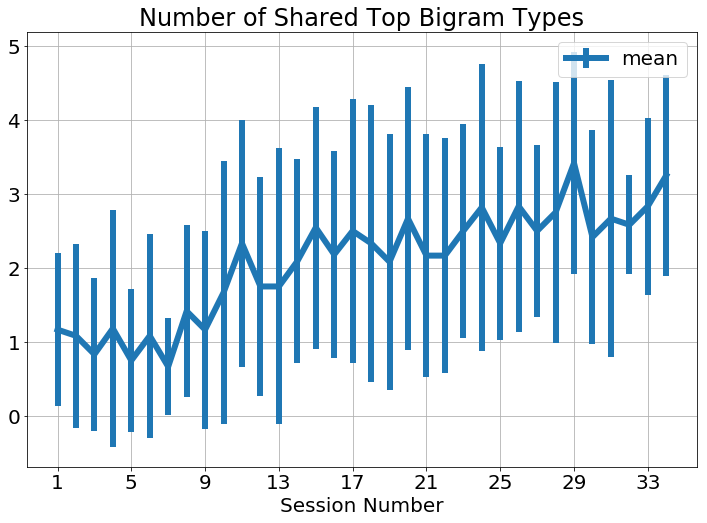

In [12]:
stats = stt[2].groupby(level='session').agg(['mean', 'std'])
plt.errorbar(stats.index, stats['mean'], stats['std']);
vvv_format(autoscale=True, title="Number of Shared Top Bigram Types")

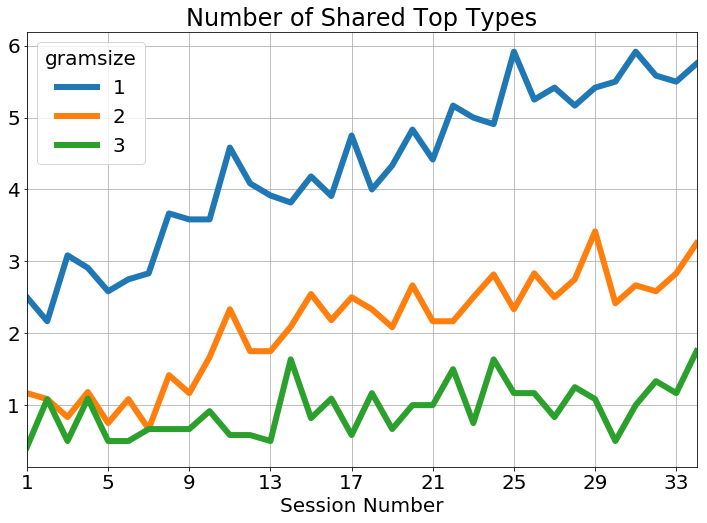

In [13]:
stt.mean(level=['gramsize', 'session']).unstack('gramsize').plot()
vvv_format(title="Number of Shared Top Types", legend=False, autoscale=True)

In [14]:
stt.mean(level='corpus')

corpus
anne     2.960784
aran     2.363636
becky    3.078431
carl     2.959596
domin    2.490196
gail     2.264706
joel     2.950980
john     2.687500
liz      2.313725
nic      1.382353
ruth     0.717172
warr     3.127451
dtype: float64

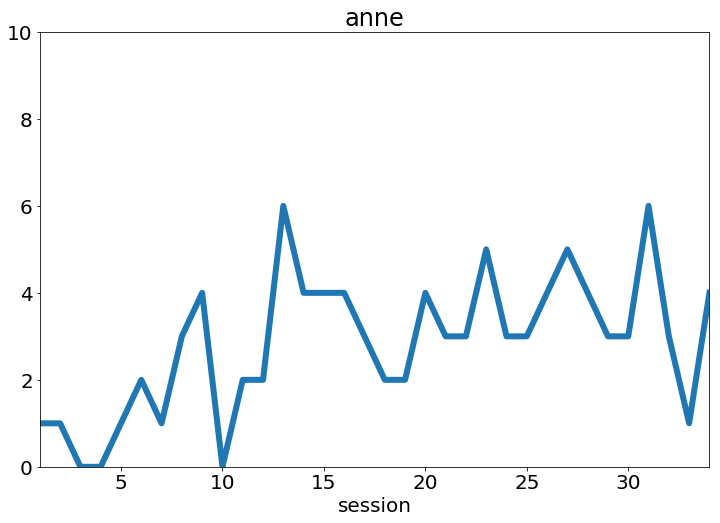

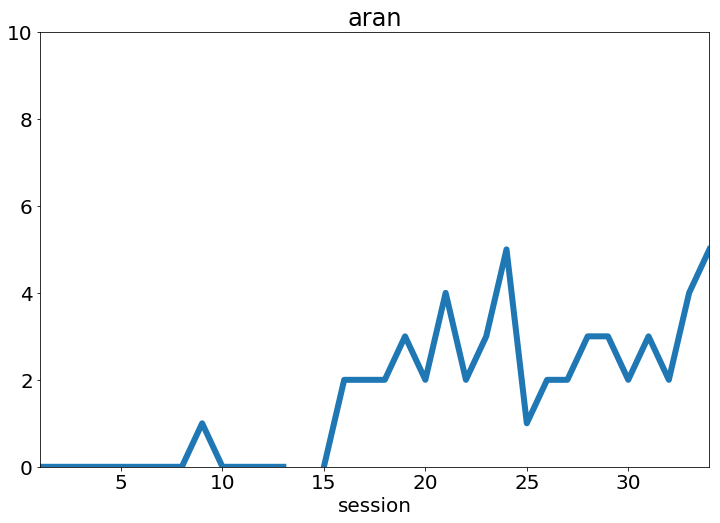

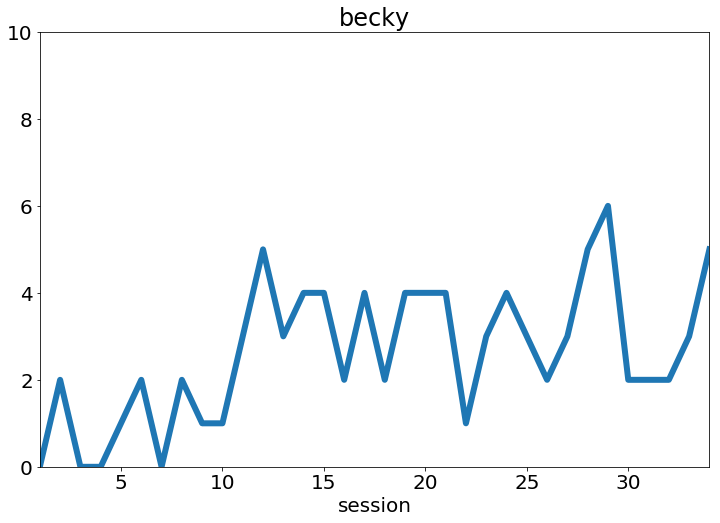

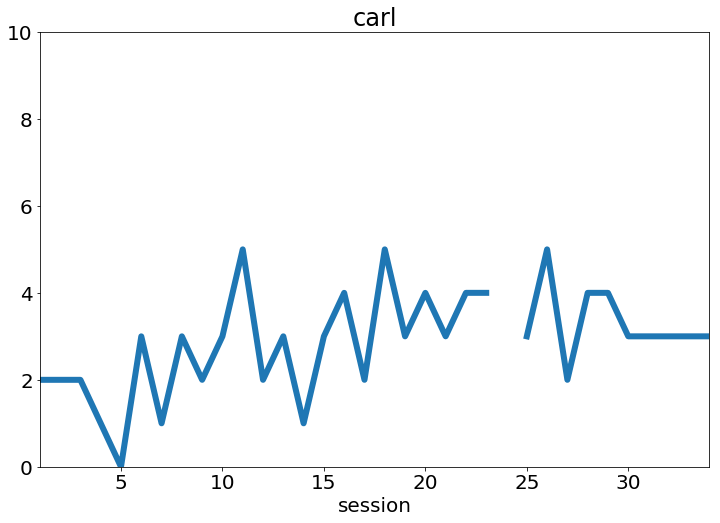

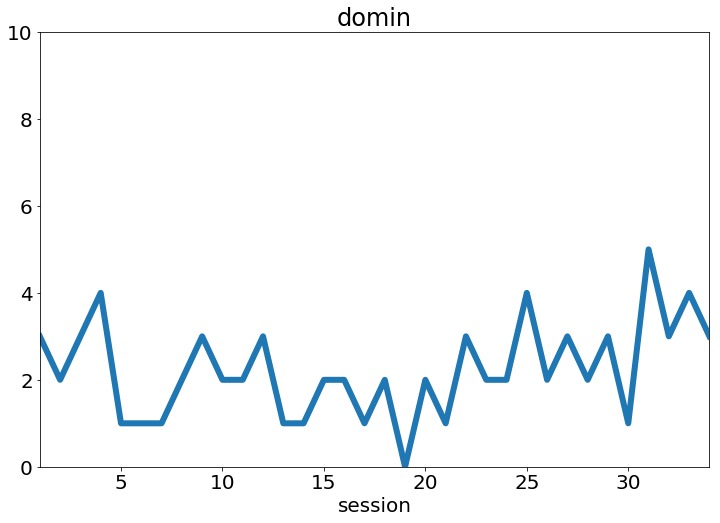

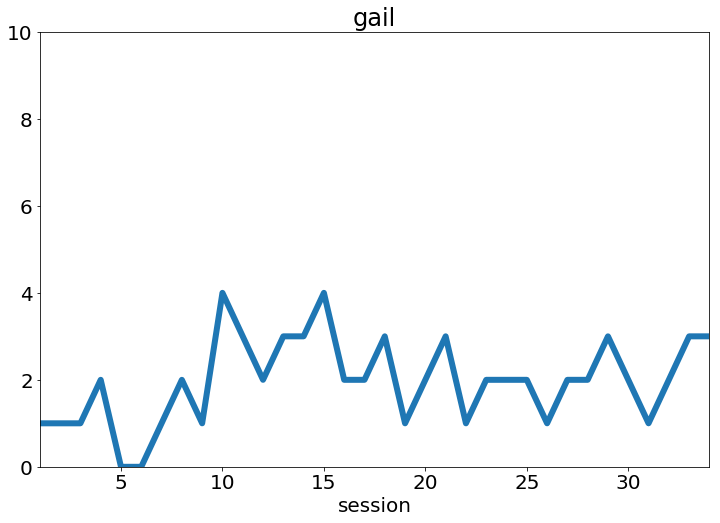

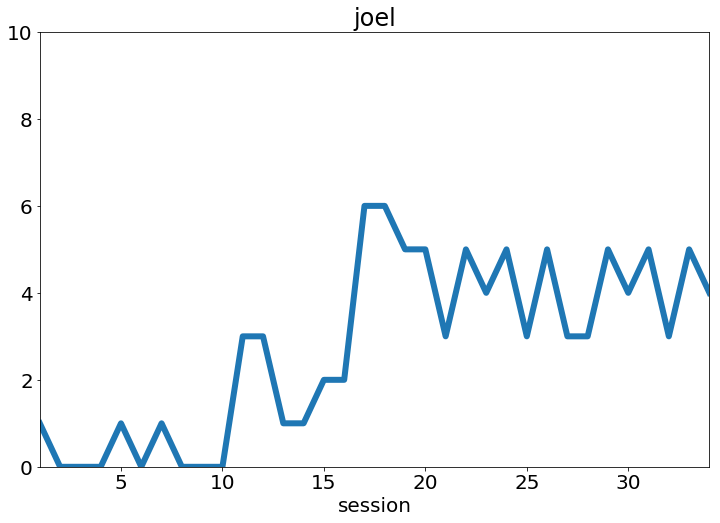

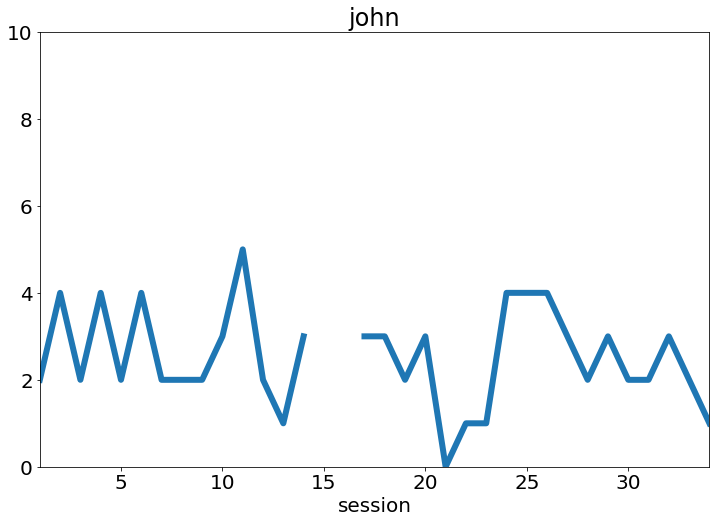

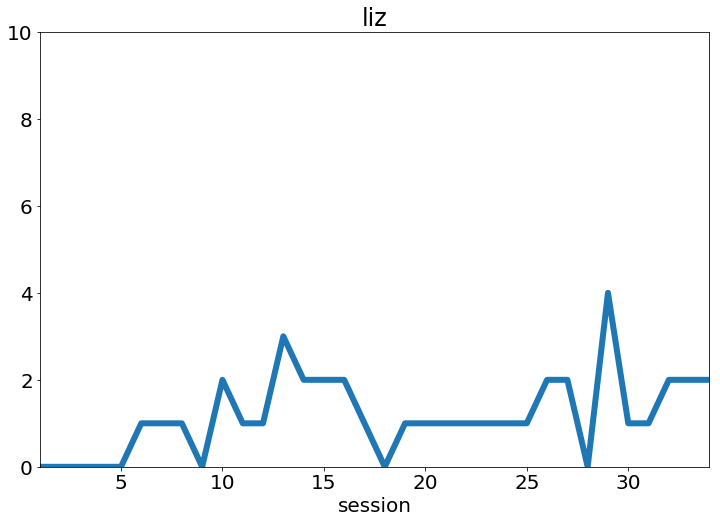

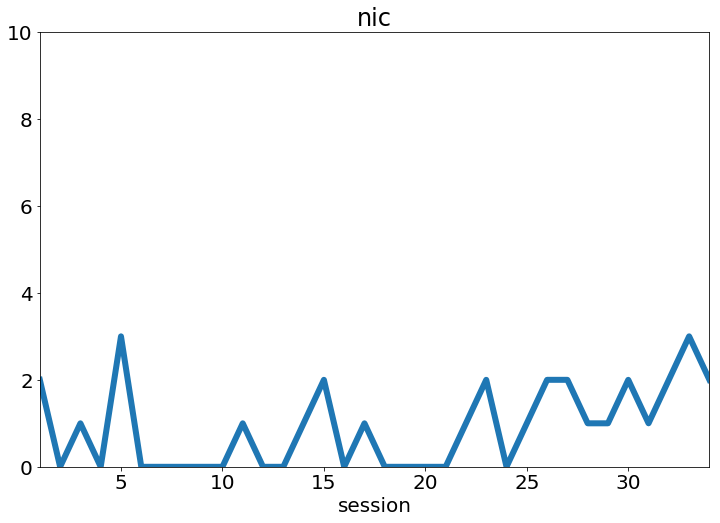

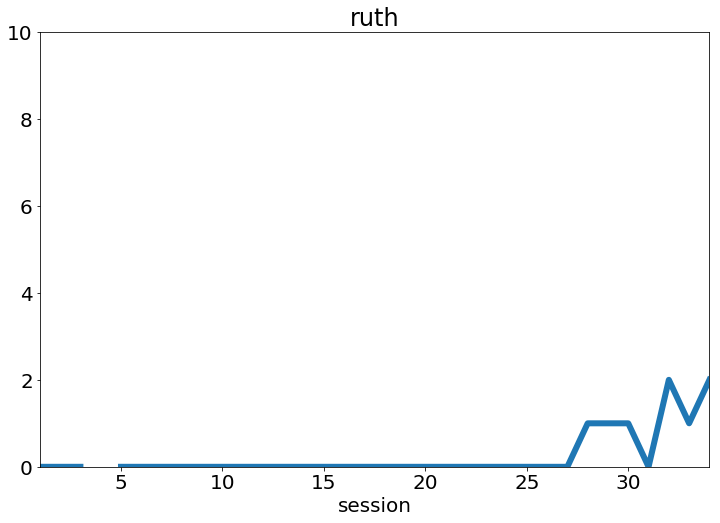

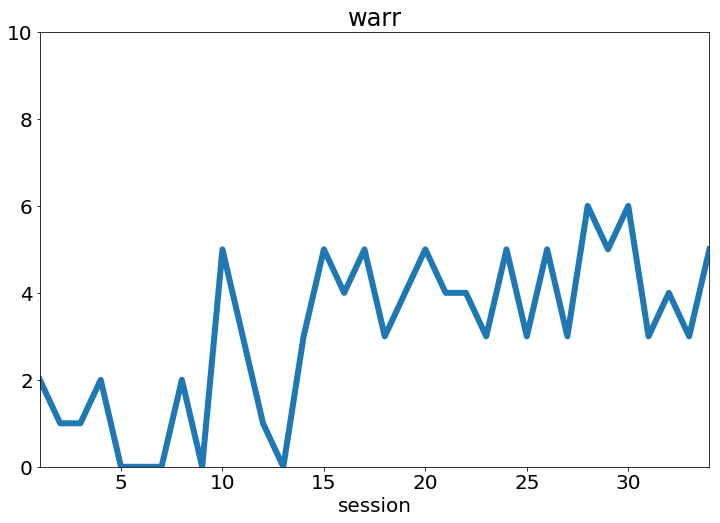

In [120]:
d = stt[2].unstack('session').T
for child in d.columns:
    axes = d[child].plot(title=child)
    axes.set_ybound(0, 10)
    plt.show()

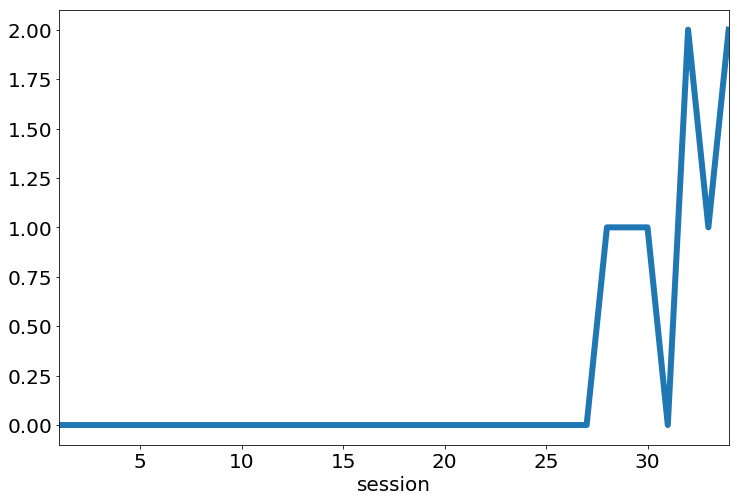

In [16]:
stt[2, 'ruth'].plot();

# John

In [113]:
john_tops = (
    grams[grams.gramsize.eq(2) & grams.corpus.eq('john')]
    .groupby(['session', 'speaker'])
    .apply(get_top_types)
)

In [115]:
john_tops[1]  # session 1

speaker                 
CHI      in the             18
         the boat           11
         it stuck            8
         it 's               8
         Mummy in            7
         do horsie           7
         byebye starfish     6
         a boat              6
         the dolly           5
         a starfish          5
         blue spider         5
MOT      it 's              36
         's a               28
         shall we           27
         that 's            26
         you want           20
         in the             17
         is it              16
         draw a             16
         what 's            16
         on the             16
Name: ngram, dtype: int64

In [116]:
john_tops[2]  # session 2

speaker              
CHI      it 's           12
         's the          12
         there 's        11
         do it            9
         's a             8
         Mummy do         8
         what 's          6
         where 's         6
         this is          6
         blue digger      5
         it stuck         5
         dumper truck     5
MOT      that 's         48
         it 's           45
         's a            30
         what 's         23
         very good       18
         shall we        18
         there 's        15
         on the          14
         's right        12
         this one        11
         you put         11
         in the          11
Name: ngram, dtype: int64

# Ruth

In [118]:
ruth_tops = (
    grams[grams.gramsize.eq(2) & grams.corpus.eq('ruth')]
    .groupby(['session', 'speaker'])
    .apply(get_top_types)
)
ruth_tops[1] # session 1

speaker            
CHI      on there      72
         in there      42
         one there      5
         I fall         4
         more tea       4
         down there     3
         baba tea       3
         some more      3
         she fall       3
         some tea       2
         no on          2
         and on         2
         oh there       2
         no baba        2
         on knee        2
         oh baba        2
         come here      2
         one in         2
MOT      that 's       49
         did you       40
         what 's       36
         's that       32
         going to      31
         is it         28
         do you        23
         it 's         22
         is she        22
         do n't        22
Name: ngram, dtype: int64

In [119]:
ruth_tops[2] # session 2

speaker              
CHI      on there        54
         in there        27
         he fall          6
         on knee          5
         it hot           3
         hey baba         3
         the baba         3
         Mama on          3
         another baba     3
         Mama there       3
         lie down         3
         a baba           3
MOT      that 's         67
         's a            31
         it 's           30
         do you          29
         what 's         29
         is she          28
         's the          28
         where 's        28
         going to        27
         is n't          24
Name: ngram, dtype: int64

# Shared Types 2

## How many of Speaker A's Top Tokens are also used by Speaker B

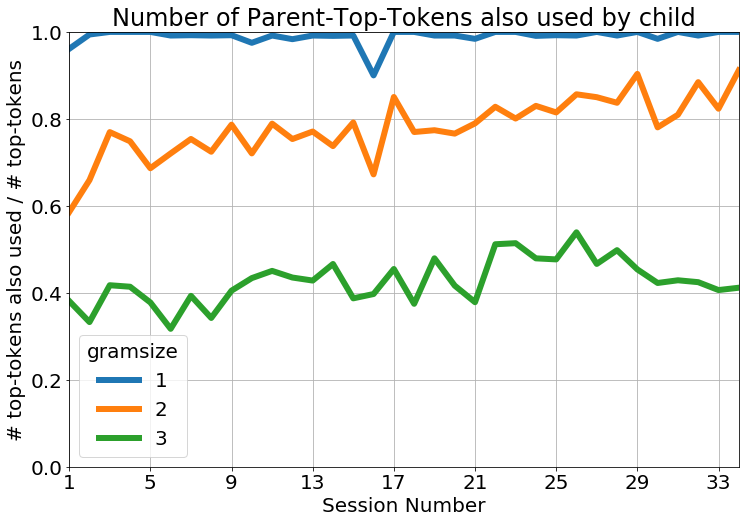

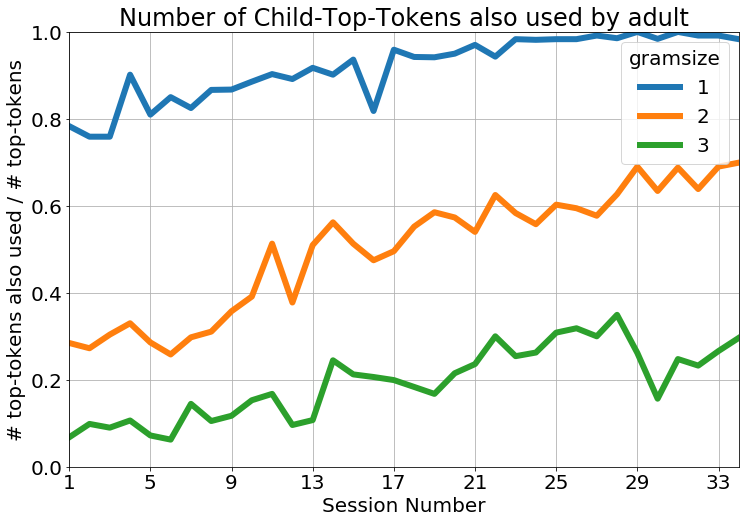

In [21]:
def num_nonunique_top_types_for_speakers(df, target, partner):
    top_types = get_top_types(df[df.speaker.eq(target)])
    other_corpus = df[df.speaker.eq(partner)].ngram
    num_shared = len(np.intersect1d(top_types.index, other_corpus))
    if num_shared == 0:
        return 0
    return  num_shared / len(top_types)

def ratio_nonunique_top_types(df):
    """ df contains data from both speakers """
    chi = num_nonunique_top_types_for_speakers(df, 'CHI', 'MOT')
    mot = num_nonunique_top_types_for_speakers(df, 'MOT', 'CHI')
    return pd.Series({'chi': chi, 'mot': mot})

st2 = (
    grams.groupby(['gramsize', 'corpus', 'session'])
    .apply(ratio_nonunique_top_types_nonunique_top_types)
)
ratios = st2.mean(level=['gramsize', 'session']).unstack('gramsize')
ratios.chi.plot()
vvv_format(title="Number of Parent-Top-Tokens also used by child", legend=False, 
           ylabel='# top-tokens also used / # top-tokens')
ratios.mot.plot()
vvv_format(title="Number of Child-Top-Tokens also used by adult", legend=False,
           ylabel='# top-tokens also used / # top-tokens')

# Child's Top Types ranked by Parent Usage

In [38]:
bigrams = grams[grams.gramsize.eq(2)]
mot_counts = bigrams[bigrams.speaker.eq('MOT')].ngram.value_counts()
mot_rankings = pd.Series(np.arange(len(mot_counts)), index=mot_counts.index)

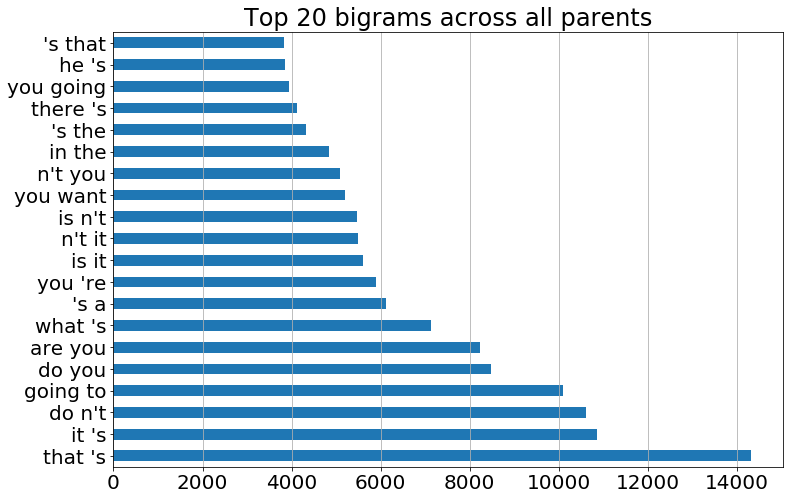

In [51]:
axes = mot_counts[:20].plot.barh(title='Top 20 bigrams across all parents')
axes.xaxis.grid()

In [168]:
d = bigrams.groupby('session').corpus.nunique()

In [220]:
def num_occurances_of_adult_top_20(df):
    child_counts = df[df.speaker.eq('MOT')].ngram.value_counts()
    return pd.Series({key: child_counts.get(key, 0)
                     for key in mot_counts[:20].index})

counts = (
    bigrams
    .groupby(['corpus', 'session'])
    .apply(num_occurances_of_adult_top_20)
)
x = counts.gt(0).sum(level='session').sub(d, axis=0).abs()

# Number of children who failed to use a  bigram, per session

In [223]:
x.loc[16] = x.astype(int).loc[16] - 1
x

,'s a,'s that,'s the,are you,do n't,do you,going to,he 's,in the,is it,is n't,it 's,n't it,n't you,that 's,there 's,what 's,you 're,you going,you want
session,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


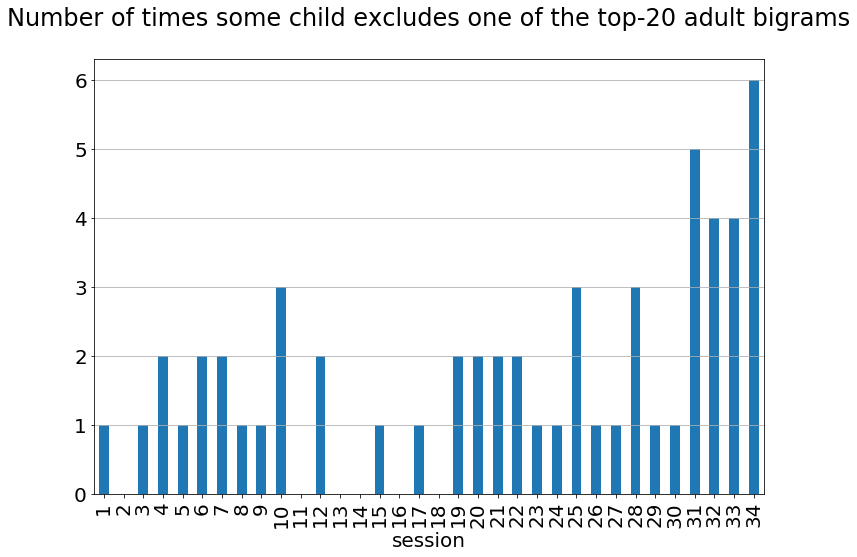

In [235]:
axes = x.sum(axis=1).plot.bar(title='Number of times some child excludes one of the top-20 adult bigrams\n');
axes.yaxis.grid()

In [52]:
sum(mot_counts)

1140107

In [111]:
def commize(num):
    """ Format a number with commas as thousands separators """
    return"{:,}".format(num)

In [109]:
grams.groupby(['gramsize', 'speaker']).size().pipe(pd.DataFrame).rename(columns={
    0: 'ngram token count'
}).applymap(commize)

ngram token count
gramsize speaker                  
1        CHI               544,677
         MOT             1,477,647
2        CHI               315,567
         MOT             1,140,107
3        CHI               185,211
         MOT               884,969

In [110]:
(
    bigrams
    .groupby(['filename', 'speaker'])
    .uid
    .apply(lambda x: x.nunique())
    .sum(level='speaker')
).pipe(pd.DataFrame).rename(columns={'uid':' number of utterances'}).applymap(commize)

,number of utterances
speaker,
CHI,"130,356"
MOT,"255,138"


In [ ]:
def uniques(df):
    chi = df[df.speaker.eq('CHI')].ngram.value_counts()
    mot = df[df.speaker.eq('MOT')].ngram.value_counts()
    top_chi = top_ten(chi).index
    top_mot = top_ten(mot).index
    
    common = np.intersect1d(chi.index, mot.index)
    top_shared = np.intersect1d(top_ten(chi).index, top_ten(mot).index)
    d = {'top_chi_unique': len(np.setdiff1d(top_chi, mot.index)),
         'top_mot_unique': len(np.setdiff1d(top_mot, chi.index)),
         'top_chi_types': len(top_chi),
         'top_mot_types': len(top_mot),
         'mot_types': len(mot),
         'chi_types': len(chi),
         'mot_tokens': len(df[df.speaker.eq('MOT')]),
         'chi_tokens': len(df[df.speaker.eq('CHI')]),
         'top_chi_tokens': sum(top_ten(chi)),
         'top_mot_tokens': sum(top_ten(mot))
        }
    if len(top_shared) > 0:
        d['top_chi_shared'] = len(top_shared) / len(top_chi)
        d['top_mot_shared'] = len(top_shared) / len(top_mot)
    else:
        d['top_chi_shared'] = d['top_mot_shared'] = 0
    d['top_shared'] = len(top_shared)
    d['common'] = len(common)
    return pd.Series(d)
    
c = (
    grams[grams.gramsize.eq(2)]
    .groupby(['corpus', 'session'])
    .apply(uniques)
)
x = c[['top_chi_unique', 'top_mot_unique']].mean(level='session')
x.columns = ['CHI', 'MOT']
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean number of unique bigram types in speaker's top 10 bigrams (with ties)", ylabel='Number of Types', autoscale=True)

x = c[['top_chi_shared', 'top_mot_shared']].mean(level='session')
x.columns = ['CHI', 'MOT']
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean ratio of shared bigram types to speaker's top ten bigrams (with ties)", ylabel='# shared types / # types in speaker top 10', autoscale=False)

In [ ]:
x = c[['top_shared']].mean(level='session')
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean number of shared bigram types", ylabel='# shared types', autoscale=True)

In [ ]:
c.top_chi_types.plot.box()

In [ ]:
c.top_mot_types.plot.box()

In [ ]:

means = c.mean(level='session')
(
    means[['top_chi_tokens', 'top_mot_tokens']]
    .rename(columns={'top_chi_tokens': 'chi', 'top_mot_tokens': 'mot'})
    .div(
        means[['chi_tokens', 'mot_tokens']]
        .rename(columns={'chi_tokens': 'chi', 'mot_tokens': 'mot'})
    )
).plot()

vvv_format(title="Ratio of speaker's types accounted for by their top-10")